In [1]:
# Credit Card Fraud Detection

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data and add hour column
df = pd.read_csv("creditcard.csv")
df['Hour'] = (df['Time'] % 86400) // 3600 

In [3]:
# Create an in-memory SQLite database
connection = sqlite3.connect(":memory:")

# Load dataframe into SQLite
df.to_sql("transactions", connection, index=False, if_exists="replace")

284807

In [4]:
# Total Transactions & Fraud Rate
total_transactions_fraud_rate_query = """
SELECT 
    COUNT(*) AS total_transactions,
    SUM(CASE WHEN Class = 1 THEN 1 ELSE 0 END) AS fraud_count,
    ROUND(100.0 * SUM(CASE WHEN Class = 1 THEN 1 ELSE 0 END) / COUNT(*), 4) AS fraud_rate_percentage
FROM transactions
"""
pd.read_sql_query(total_transactions_fraud_rate_query, connection)

,total_transactions,fraud_count,fraud_rate_percentage
0,284807,492,0.1727


In [5]:
# Amount Stats (Fraud vs. Non-Fraud)
amount_stats_query = """
SELECT 
    Class,
    COUNT(*) AS total,
    AVG(Amount) AS avg_amount,
    MAX(Amount) AS max_amount,
    MIN(Amount) AS min_amount
FROM transactions
GROUP BY Class
"""
pd.read_sql_query(amount_stats_query, connection)

,Class,total,avg_amount,max_amount,min_amount
0,0,284315,88.291022,25691.16,0.0
1,1,492,122.211321,2125.87,0.0


In [6]:
# High-Value Fraud Transactions
high_value_fraud_transactions_query = """
SELECT *
FROM transactions
WHERE Amount > 1000 AND Class = 1
ORDER BY Amount DESC
LIMIT 10
"""
pd.read_sql_query(high_value_fraud_transactions_query, connection)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
0,122608.0,-2.003460,-7.159042,-4.050976,1.309580,-2.058102,-0.098621,2.880083,-0.727484,1.460381,...,-1.015232,-1.800985,0.657586,-0.435617,-0.894509,-0.397557,0.314262,2125.87,1,10.0
1,9064.0,-3.499108,0.258555,-4.489558,4.853894,-6.974522,3.628382,5.431271,-1.946734,-0.775680,...,0.204817,-2.119007,0.170279,-0.393844,0.296367,1.985913,-0.900452,1809.68,1,2.0
2,154278.0,-1.600211,-3.488130,-6.459303,3.246816,-1.614608,-1.260375,0.288223,-0.048964,-0.734975,...,-0.967141,-1.463421,-0.624231,-0.176462,0.400348,0.152947,0.477775,1504.93,1,18.0
3,62467.0,-5.344665,-0.285760,-3.835616,5.337048,-7.609909,3.874668,1.289630,0.201742,-3.003532,...,1.342045,-1.016579,-0.071361,-0.335869,0.441044,1.520613,-1.115937,1402.16,1,17.0
4,59011.0,-2.326922,-3.348439,-3.513408,3.175060,-2.815137,-0.203363,-0.892144,0.333226,-0.802005,...,-0.695902,-1.478490,-0.061553,0.236155,0.531911,0.302324,0.536375,1389.56,1,16.0
5,65385.0,-2.923827,1.524837,-3.018758,3.289291,-5.755542,2.218276,-0.509995,-3.569444,-1.016592,...,-0.122724,-4.288639,0.563797,-0.949451,-0.204532,1.510206,-0.324706,1354.25,1,18.0
6,133184.0,-1.212682,-2.484824,-6.397186,3.670562,-0.863375,-1.855855,1.017732,-0.544704,-1.703378,...,0.092073,-1.492882,-0.204227,0.532511,-0.293871,0.212663,0.431095,1335.00,1,12.0
7,18088.0,-12.224021,3.854150,-12.466766,9.648311,-2.726961,-4.445610,-21.922811,0.320792,-4.433162,...,-1.504119,-19.254328,0.544867,-4.781606,-0.007772,3.052358,-0.775036,1218.89,1,5.0
8,154309.0,-0.082983,-3.935919,-2.616709,0.163310,-1.400952,-0.809419,1.501580,-0.471000,1.519743,...,-0.182305,-0.921017,0.111635,-0.071622,-1.125881,-0.170947,0.126221,1096.99,1,18.0


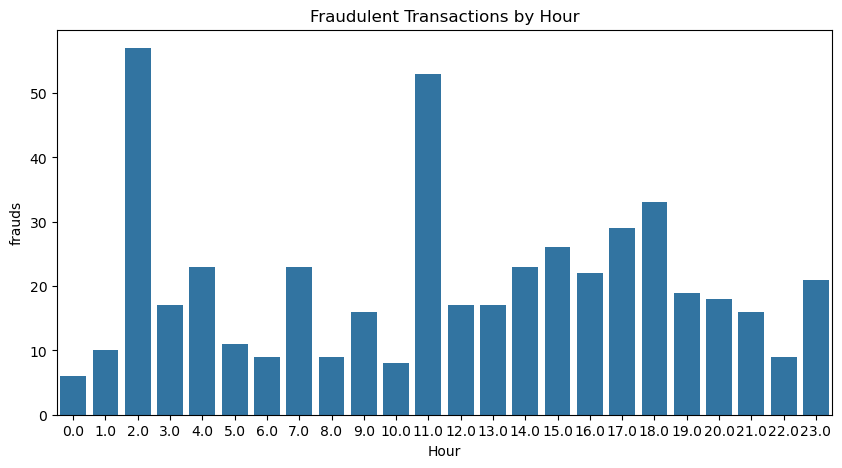

In [7]:
# Time-Based Fraud Patterns
fraud_patterns_query = """
SELECT 
    Hour,
    COUNT(*) AS total_transactions,
    SUM(CASE WHEN Class = 1 THEN 1 ELSE 0 END) AS frauds
FROM transactions
GROUP BY Hour
ORDER BY Hour
"""
hourly_fraud = pd.read_sql_query(fraud_patterns_query, connection)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(data=hourly_fraud, x='Hour', y='frauds')
plt.title("Fraudulent Transactions by Hour")
plt.show()

In [8]:
# Fraud Score Heuristic
fraud_score_query = """
SELECT Amount, V1, V2, Class,
       ((CASE WHEN Amount > 200 THEN 1 ELSE 0 END) +
        (CASE WHEN ABS(V1) > 2 THEN 1 ELSE 0 END) +
        (CASE WHEN ABS(V2) > 2 THEN 1 ELSE 0 END)) AS fraud_score
FROM transactions
ORDER BY fraud_score DESC
LIMIT 10
"""
pd.read_sql_query(fraud_score_query, connection)

,Amount,V1,V2,Class,fraud_score
0,200.01,-4.575093,-4.429184,0,3
1,3828.04,-6.093248,-12.114213,0,3
2,937.69,-4.816022,-3.345061,0,3
3,500.00,-3.494861,-2.894450,0,3
4,355.51,-4.066862,-5.081215,0,3
5,456.71,-3.495984,-4.088420,0,3
6,529.00,-3.043541,-3.157307,1,3
7,1015.61,-2.752124,-3.232168,0,3
8,986.31,-2.618386,-2.302449,0,3
9,589.21,-2.829522,-3.027379,0,3


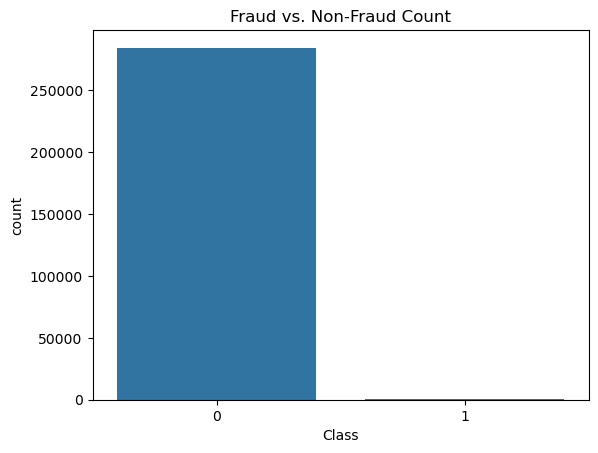

In [9]:
# Visualize Class Distribution
class_distribution_query = "SELECT Class, COUNT(*) as count FROM transactions GROUP BY Class"
class_dist = pd.read_sql_query(class_distribution_query, connection)

sns.barplot(data=class_dist, x='Class', y='count')
plt.title("Fraud vs. Non-Fraud Count")
plt.show()